# Parsing Raw AR Data

This is an initial cut on the list of ARs observed over multiple rotations from https://zenodo.org/records/8336354

1. Find the times when each AR with given NOAA number was near disk center
2. Get the GOES XRS lightcurve starting 6 hours before the first time and 6 hours after the last time
3. For each row, plot the GOES lightcurve, highlighting each segment +/- 6 around the time at disk center for each AR
4. For those ARs that show flaring activity, check HEK for those times to get bounding boxes of flares
5. Check whether those flare bounding boxes intersect with AR bounding boxes. If yes, exclude.
6. For remaining ARs, get HMI data (synoptic or HPC?)

What do I acutall

In [58]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import astropy.table
from astropy.io import ascii
import astropy.coordinates

import sunpy.timeseries
from sunpy.net import Fido, attrs as a
import sunpy.coordinates

In [112]:
ar_table = ascii.read('../data/RAR_classifications_2011_2019_v2.csv')
rows = []
for r in ar_table:
    for c in r:
        rows += [{'ID': r[0], 'NOAA Number': c}]
ar_table = astropy.table.QTable(data=rows)
ar_table.remove_rows(np.where(ar_table['NOAA Number'].mask)[0])

In [116]:
reduced_ar_table = []
for group in ar_table.group_by('ID').groups:
    #if len(group) > 2:
    reduced_ar_table.append(group)
reduced_ar_table = astropy.table.vstack(reduced_ar_table)

In [44]:
q = Fido.search(a.Time('2011-01-01','2020-01-01'), a.hek.AR.NOAANum==12644)

In [60]:
q['hek'][0]['event_coord']

<SkyCoord (ICRS): (ra, dec) in deg
    (301.51883316, 12.82006264)>

In [55]:
foo = q['hek'][0]['hpc_coord']

In [59]:
foo.center.transform_to(astropy.coordinates.ICRS)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, AU)
    (84.87283501, 32.51501392, 0.00824881)>

In [25]:
q['hek'][0]

gs_thumburl,comment_count,hpc_bbox,meanphotoenergydensity,frm_humanflag,hgc_coord,ar_spotarearepruncert,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,meantwistalpha,intensmin,obs_meanwavel,frm_url,bound_chaincode,totalphotoenergy,noposition,ar_spotarearepr,active,intensmax,frm_versionnumber,ar_pilcurvature,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,hpc_boundcc,event_mapurl,frm_contact,meanvertcurrentdensity,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,ar_spotarearaw,unsignedflux,boundbox_c2ur,highshearareapercent,obs_firstprocessingdate,sharp_noaa_ars,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,meangradienthorz,gwill,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,event_expires,hrc_boundcc,event_probability,intensvar,frm_daterun,highsheararea,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,unsignedvertcurrent,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,kb_archivid,search_frm_name,meaninclinationgamma,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,absnetcurrenthelicity,meancurrenthelicity,event_importance_num_ratings,ar_compactnesscls,event_testflag,maxmagfieldstrength,event_c2error,hrc_r,hgs_y,obs_title,hgs_x,hcr_checked,frm_specificid,totalphotoenergydensity,event_title,ar_sumnegsignedflux,obs_instrument,ar_neutrallength,event_c1error,revision,hpc_radius,meanshearangle,event_endtime,ar_spotarearawuncert,event_importance,meangradienttotal,search_observatory,ar_sumpossignedflux,area_raw,meangradientvert,concept,ar_axislength,solar_object_locator,hgc_boundcc,log_r_value,hgc_x,hrc_a,hgc_y,gs_galleryid,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,rasterscantype,search_channelid,unsignedcurrenthelicity,hgs_bbox,savncpp,obs_lastprocessingdate,refs,fl_goescls,fl_fluence,fl_peaktemp,wavelmaxrange,oscillnperiodsuncert,freqmaxrange,freqpeakpower,freqminrange,wavedisplminampl,velocmaxpower,intensmaxampl,skel_startc2,intensminampl,wavelmaxpower,wavelminrange,velocmaxampl,wavedisplmaxampl,skel_curvature,skel_chaincode,fl_halphaclass,velocminampl,skel_startc1,peakpower,fl_peakem,fl_peakflux,velocmaxpoweruncert,oscillnperiods,wavelmaxpoweruncert,skel_nsteps,fl_efoldtime,event_peaktime,event_coord
str1,str1,object,object,str5,object,object,str12,object,object,object,str1,object,str44,object,Time,str16,str2,object,object,object,str55,str1,object,str5,object,str4,object,object,object,object,str1,str186,object,object,str1,str9,str1,str1,str30,object,str2,str1,str1,str43,object,str1,object,object,str18,object,str23,str7,str95,object,object,object,object,str1,object,object,str61,object,str1,object,object,str3,str1,object,str1,str23,str1,str1,object,object,str19,object,float64,float64,str4,object,str19,str13,object,str21,object,str1,object,str1,str1,str82,str9,object,object,int64,object,object,object,object,str1,str1,str5,object,object,float64,float64,str1,float64,str5,str4,object,str1,object,str7,object,object,str1,str19,object,Time,object,object,object,str4,object,object,object,str13,object,str30,str1,object,float64,float64,float64,str1,object,str1,object,object,str1,str1,str7,object,object,object,str1,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
,0,"Region: PolygonSkyRegion\nvertices: <SkyCoord (Helioprojective: obstime=2017-03-25 00:24:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec\n [(-811.1097, 265.641768), (-796.7532, 268.520388),\n (-793.4484, 284.825532), (-807.7458, 281.956992),\n (-811.1097, 265.6

In [63]:
new_rows = []
col_mappings = {
    'ar_noaanum': 'NOAA',
    'hpc_bbox': 'Region',
    #'hpc_x',
    #'hpc_y',
    #'event_starttime',
    #'event_endtime',
}
# Set to include the whole time range over which the ARs were collected
time_range = a.Time('2011-01-01','2020-01-01')
for row in reduced_ar_table[:2]:
    new_row = {'NOAA': row['R1']}
    for col,col_name in zip(row,row.colnames):
        if np.ma.is_masked(col):
            for _,val in col_mappings.items():
                new_row[f'{col_name} {val}'] = np.ma.masked
        else:
            q = Fido.search(time_range, a.hek.AR.NOAANum==col)
            # This probably returns many results. Find the one closest to disk center
            mean_tx = u.Quantity([r.vertices.Tx.mean() for r in q['hek']['hpc_bbox']])
            i_sel = np.argmin(np.fabs(mean_tx.value))
            for key,val in col_mappings.items():
                new_row[f'{col_name} {val}'] = q['hek'][i_sel][key]
    new_rows.append(new_row)
new_ar_table = astropy.table.QTable(new_rows)

In [11]:
new_ar_table

NOAA,R1 ar_noaanum,R1 hpc_x,R1 hpc_y,R1 event_starttime,R1 event_endtime,R2 ar_noaanum,R2 hpc_x,R2 hpc_y,R2 event_starttime,R2 event_endtime,R3 ar_noaanum,R3 hpc_x,R3 hpc_y,R3 event_starttime,R3 event_endtime,R4 ar_noaanum,R4 hpc_x,R4 hpc_y,R4 event_starttime,R4 event_endtime
,,arcsec,arcsec,,,,arcsec,arcsec,,,,arcsec,arcsec,,,,arcsec,arcsec,,
int64,int64,float64,float64,Time,Time,int64,float64,float64,Time,Time,int64,float64,float64,Time,Time,int64,float64,float64,object,object
11401,11401,0.0,75.7362,2012-01-14 12:00:00.000,2012-01-14 12:20:00.000,11420,66.7818,300.4584,2012-02-19 00:00:00.000,2012-02-19 23:59:59.000,11433,0.0,121.851,2012-03-11 10:58:00.000,2012-03-11 11:13:00.000,--,0.0,0.0,--,--
11504,11504,0.0,-6.43818,2012-06-09 11:20:00.000,2012-06-09 11:35:00.000,11520,0.0,-59.21328,2012-07-07 08:18:00.000,2012-07-07 08:39:00.000,11541,-369.2328,-365.5842,2012-08-07 00:00:00.000,2012-08-07 23:59:59.000,--,0.0,0.0,--,--
11575,11575,0.0,-119.4756,2012-09-17 11:35:00.000,2012-09-17 12:01:00.000,11591,0.0,-99.4032,2012-10-14 06:27:00.000,2012-10-14 06:37:00.000,11612,84.0666,88.176,2012-11-15 00:00:00.000,2012-11-15 23:59:59.000,--,0.0,0.0,--,--
11753,11753,66.08751,105.689736,2013-05-26 00:00:00.000,2013-05-26 23:59:59.000,11773,14.2152,27.12468,2013-06-20 20:00:00.000,2013-06-21 00:00:00.000,11792,0.0,-71.7096,2013-07-15 02:33:00.000,2013-07-15 03:03:00.000,--,0.0,0.0,--,--
11907,11907,16.76184,-205.8894,2013-11-28 12:00:00.000,2013-11-28 16:00:00.000,11934,0.0,26.23656,2013-12-19 23:06:00.000,2013-12-19 23:26:00.000,11949,12.22488,-209.6202,2014-01-15 00:00:00.000,2014-01-15 04:00:00.000,--,0.0,0.0,--,--
12156,12156,-763.59,179.9598,2014-09-05 00:00:00.000,2014-09-05 23:59:59.000,12183,-7.96644,116.5128,2014-10-07 16:00:00.000,2014-10-07 20:00:00.000,12195,1.9689,77.9262,2014-10-28 20:00:00.000,2014-10-29 00:00:00.000,--,0.0,0.0,--,--
12192,12192,0.0,-97.5414,2014-10-16 07:31:00.000,2014-10-16 07:47:00.000,12209,0.0,-52.3134,2014-11-13 05:58:00.000,2014-11-13 06:13:00.000,12237,0.0,13.48434,2014-12-14 08:04:00.000,2014-12-14 08:12:00.000,--,0.0,0.0,--,--
12271,12271,0.0,94.5186,2015-01-26 05:07:00.000,2015-01-26 05:54:00.000,12290,0.0,121.998,2015-02-28 13:35:00.000,2015-02-28 13:46:00.000,12303,0.0,114.7476,2015-03-26 16:05:00.000,2015-03-26 16:22:00.000,12324,0.0,92.184,2015-04-16 18:04:00.000,2015-04-16 18:24:00.000


In [25]:
for rot in ['R1', 'R2', 'R3']:
    delta_t = (new_ar_table[f'{rot} event_endtime'] - new_ar_table[f'{rot} event_starttime'])
    new_ar_table[f'{rot} event_avgtime'] = new_ar_table[f'{rot} event_starttime'] + delta_t/2

In [26]:
new_ar_table

NOAA,R1 ar_noaanum,R1 hpc_x,R1 hpc_y,R1 event_starttime,R1 event_endtime,R2 ar_noaanum,R2 hpc_x,R2 hpc_y,R2 event_starttime,R2 event_endtime,R3 ar_noaanum,R3 hpc_x,R3 hpc_y,R3 event_starttime,R3 event_endtime,R4 ar_noaanum,R4 hpc_x,R4 hpc_y,R4 event_starttime,R4 event_endtime,R1 event_avgtime,R2 event_avgtime,R3 event_avgtime
,,arcsec,arcsec,,,,arcsec,arcsec,,,,arcsec,arcsec,,,,arcsec,arcsec,,,,,
int64,int64,float64,float64,Time,Time,int64,float64,float64,Time,Time,int64,float64,float64,Time,Time,int64,float64,float64,object,object,Time,Time,Time
11401,11401,0.0,75.7362,2012-01-14 12:00:00.000,2012-01-14 12:20:00.000,11420,66.7818,300.4584,2012-02-19 00:00:00.000,2012-02-19 23:59:59.000,11433,0.0,121.851,2012-03-11 10:58:00.000,2012-03-11 11:13:00.000,--,0.0,0.0,--,--,2012-01-14 12:10:00.000,2012-02-19 11:59:59.500,2012-03-11 11:05:30.000
11504,11504,0.0,-6.43818,2012-06-09 11:20:00.000,2012-06-09 11:35:00.000,11520,0.0,-59.21328,2012-07-07 08:18:00.000,2012-07-07 08:39:00.000,11541,-369.2328,-365.5842,2012-08-07 00:00:00.000,2012-08-07 23:59:59.000,--,0.0,0.0,--,--,2012-06-09 11:27:30.000,2012-07-07 08:28:30.000,2012-08-07 11:59:59.500
11575,11575,0.0,-119.4756,2012-09-17 11:35:00.000,2012-09-17 12:01:00.000,11591,0.0,-99.4032,2012-10-14 06:27:00.000,2012-10-14 06:37:00.000,11612,84.0666,88.176,2012-11-15 00:00:00.000,2012-11-15 23:59:59.000,--,0.0,0.0,--,--,2012-09-17 11:48:00.000,2012-10-14 06:32:00.000,2012-11-15 11:59:59.500
11753,11753,66.08751,105.689736,2013-05-26 00:00:00.000,2013-05-26 23:59:59.000,11773,14.2152,27.12468,2013-06-20 20:00:00.000,2013-06-21 00:00:00.000,11792,0.0,-71.7096,2013-07-15 02:33:00.000,2013-07-15 03:03:00.000,--,0.0,0.0,--,--,2013-05-26 11:59:59.500,2013-06-20 22:00:00.000,2013-07-15 02:48:00.000
11907,11907,16.76184,-205.8894,2013-11-28 12:00:00.000,2013-11-28 16:00:00.000,11934,0.0,26.23656,2013-12-19 23:06:00.000,2013-12-19 23:26:00.000,11949,12.22488,-209.6202,2014-01-15 00:00:00.000,2014-01-15 04:00:00.000,--,0.0,0.0,--,--,2013-11-28 14:00:00.000,2013-12-19 23:16:00.000,2014-01-15 02:00:00.000
12156,12156,-763.59,179.9598,2014-09-05 00:00:00.000,2014-09-05 23:59:59.000,12183,-7.96644,116.5128,2014-10-07 16:00:00.000,2014-10-07 20:00:00.000,12195,1.9689,77.9262,2014-10-28 20:00:00.000,2014-10-29 00:00:00.000,--,0.0,0.0,--,--,2014-09-05 11:59:59.500,2014-10-07 18:00:00.000,2014-10-28 22:00:00.000
12192,12192,0.0,-97.5414,2014-10-16 07:31:00.000,2014-10-16 07:47:00.000,12209,0.0,-52.3134,2014-11-13 05:58:00.000,2014-11-13 06:13:00.000,12237,0.0,13.48434,2014-12-14 08:04:00.000,2014-12-14 08:12:00.000,--,0.0,0.0,--,--,2014-10-16 07:39:00.000,2014-11-13 06:05:30.000,2014-12-14 08:08:00.000
12271,12271,0.0,94.5186,2015-01-26 05:07:00.000,2015-01-26 05:54:00.000,12290,0.0,121.998,2015-02-28 13:35:00.000,2015-02-28 13:46:00.000,12303,0.0,114.7476,2015-03-26 16:05:00.000,2015-03-26 16:22:00.000,12324,0.0,92.184,2015-04-16 18:04:00.000,2015-04-16 18:24:00.000,2015-01-26 05:30:30.000,2015-02-28 13:40:30.000,2015-03-26 16:13:30.000


In [35]:
timeseries = []
for row in new_ar_table:
    times_avg = astropy.time.Time([row[c] for c in row.colnames
                                     if 'avgtime' in c and not np.ma.is_masked(row[c])])
    #times_end = astropy.time.Time([row[c] for c in row.colnames
    #                                 if 'endtime' in c and not np.ma.is_masked(row[c])])
    ranges = a.AttrOr([a.Time(t-6*u.h, t+6*u.h) for t in times_avg])
    q = Fido.search(ranges, a.Instrument.xrs, a.goes.SatelliteNumber(15), a.Resolution('flx1s'))
    print(q)
    files = Fido.fetch(q, path='../data/{instrument}')
    ts = sunpy.timeseries.TimeSeries(files, concatenate=True)
    timeseries.append(ts)

Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2012-01-14 00:00:00.000 2012-01-14 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2012-02-19 00:00:00.000 2012-02-19 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Sourc

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.24file/s]


Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2012-06-09 00:00:00.000 2012-06-09 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2012-07-07 00:00:00.000 2012-07-07 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Sourc

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.10file/s]


Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2012-09-17 00:00:00.000 2012-09-17 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2012-10-14 00:00:00.000 2012-10-14 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Sourc

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.25file/s]


Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2013-05-26 00:00:00.000 2013-05-26 23:59:59.999 ...     NOAA      flx1s

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2013-06-20 00:00:00.000 2013-06-20 23:59:59.999 ...     NOAA      flx1s
2013-06-21 00:00:00.000 2013-06-21 2

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.62file/s]


Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2013-11-28 00:00:00.000 2013-11-28 23:59:59.999 ...     NOAA      flx1s

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2013-12-19 00:00:00.000 2013-12-19 23:59:59.999 ...     NOAA      flx1s
2013-12-20 00:00:00.000 2013-12-20 2

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98file/s]


Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2014-09-05 00:00:00.000 2014-09-05 23:59:59.999 ...     NOAA      flx1s

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2014-10-07 00:00:00.000 2014-10-07 23:59:59.999 ...     NOAA      flx1s
2014-10-08 00:00:00.000 2014-10-08 2

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.28file/s]


Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2014-10-16 00:00:00.000 2014-10-16 23:59:59.999 ...     NOAA      flx1s

0 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

<No columns>

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-sate

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.36file/s]


Results from 3 Providers:

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2015-01-25 00:00:00.000 2015-01-25 23:59:59.999 ...     NOAA      flx1s
2015-01-26 00:00:00.000 2015-01-26 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2015-02-28 00:00:00.000 2015-02-28 2

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.95file/s]


Results from 3 Providers:

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2015-02-28 00:00:00.000 2015-02-28 23:59:59.999 ...     NOAA      flx1s

1 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2015-03-26 00:00:00.000 2015-03-26 23:59:59.999 ...     NOAA      flx1s

2 Results from the XRSClient:
Sourc

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81file/s]


Results from 3 Providers:

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2015-09-19 00:00:00.000 2015-09-19 23:59:59.999 ...     NOAA      flx1s
2015-09-20 00:00:00.000 2015-09-20 23:59:59.999 ...     NOAA      flx1s

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2015-10-17 00:00:00.000 2015-10-17 2

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28file/s]


Results from 3 Providers:

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2016-05-19 00:00:00.000 2016-05-19 23:59:59.999 ...     NOAA      flx1s
2016-05-20 00:00:00.000 2016-05-20 23:59:59.999 ...     NOAA      flx1s

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2016-06-20 00:00:00.000 2016-06-20 2

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68file/s]


Results from 3 Providers:

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2017-03-25 00:00:00.000 2017-03-25 23:59:59.999 ...     NOAA      flx1s
2017-03-26 00:00:00.000 2017-03-26 23:59:59.999 ...     NOAA      flx1s

2 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Provider Resolution
----------------------- ----------------------- ... -------- ----------
2017-04-16 00:00:00.000 2017-04-16 2

Files Downloaded: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.21file/s]


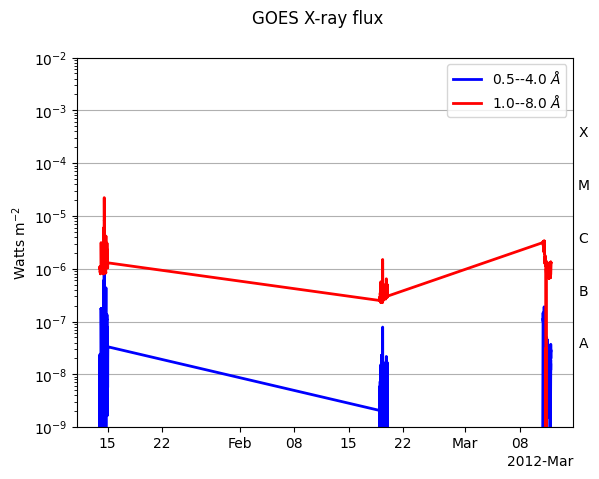

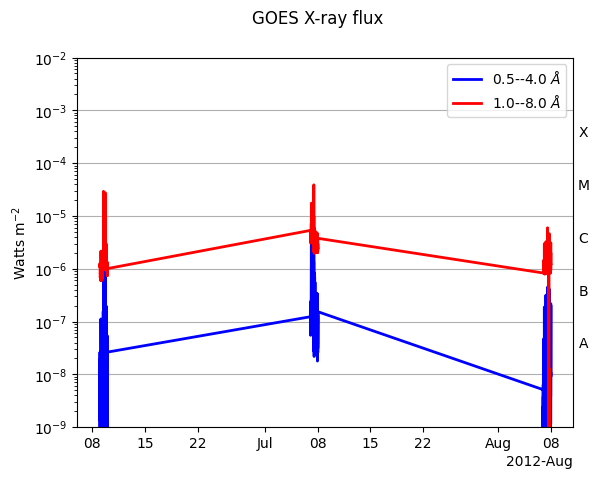

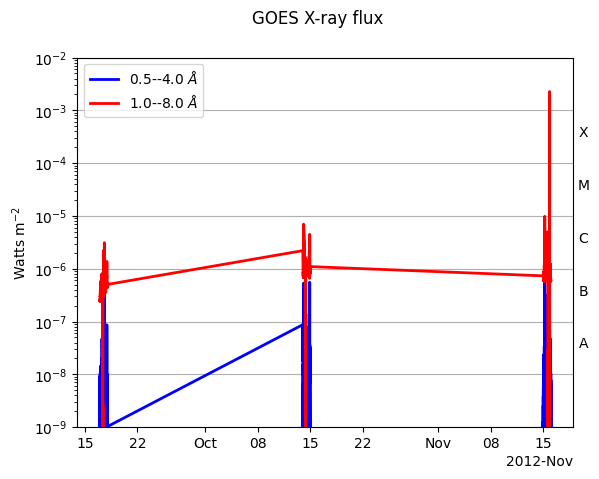

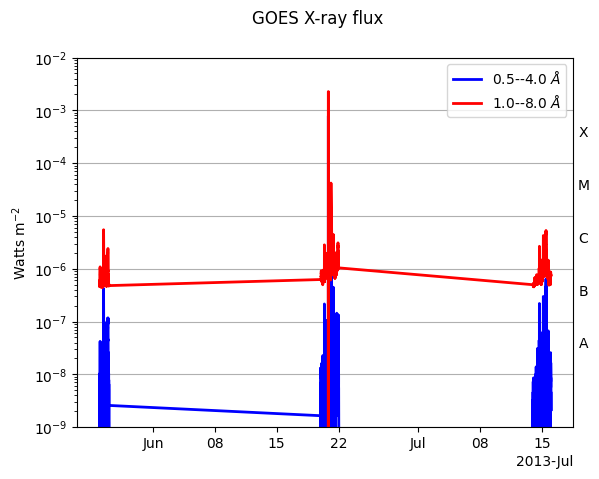

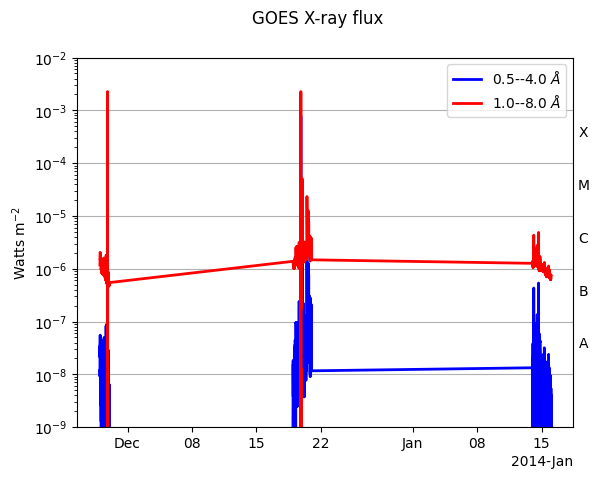

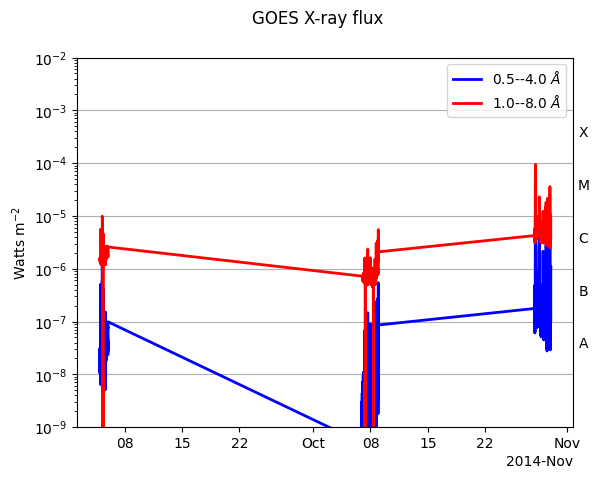

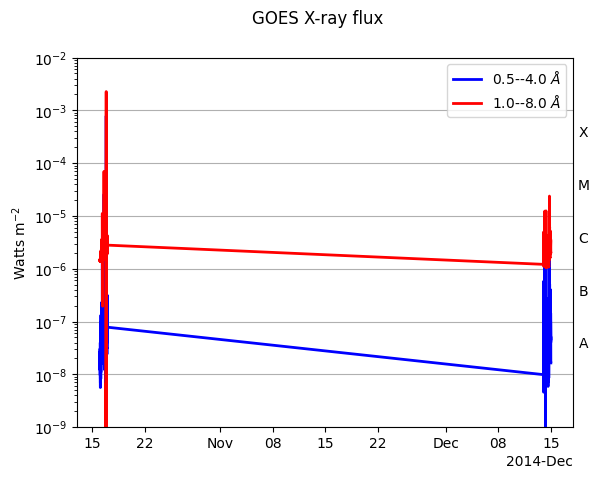

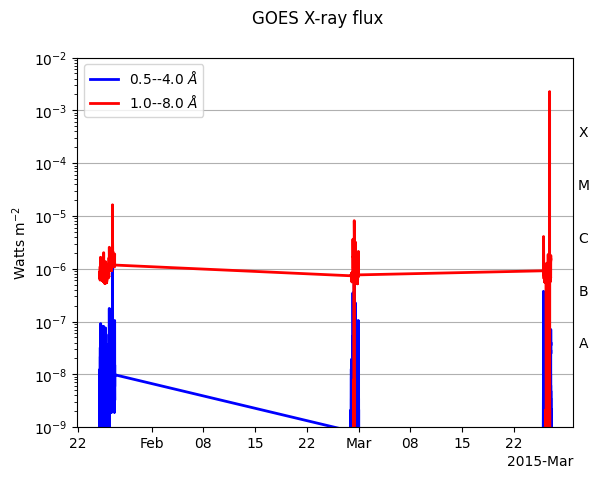

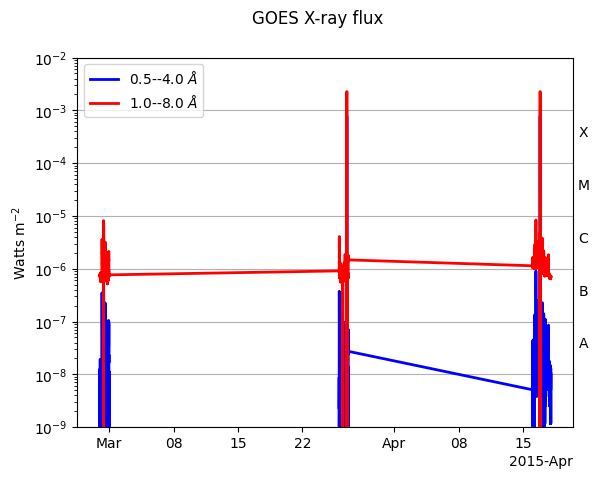

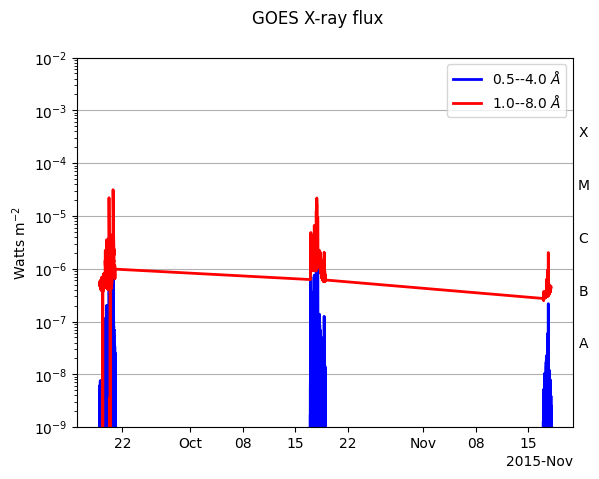

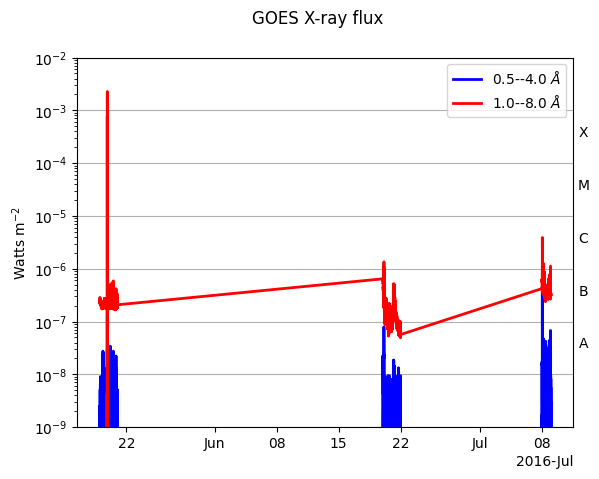

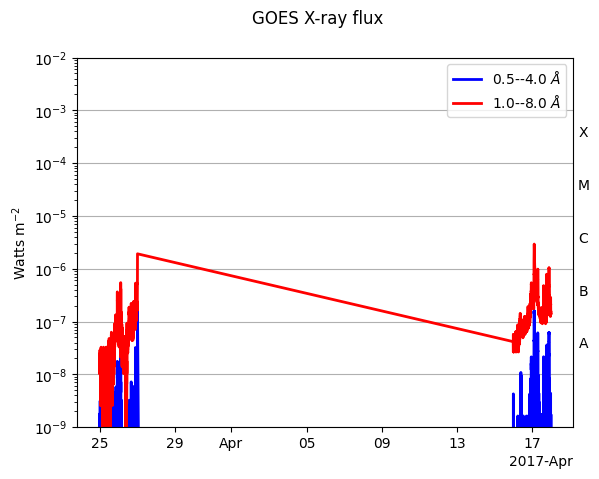

In [38]:
for ts in timeseries:
    ts.peek()

In [19]:
times.max()

<Time object: scale='utc' format='iso' value=2017-05-18 16:44:00.000>

In [119]:
import astropy.constants as const

In [122]:
const.e.name

'Electron charge'